In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import tqdm
import glob
import urllib.request
import torchvision
import torch
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
import pickle


%matplotlib inline

In [3]:
image_map_file = 'image_map_resnet50_places365.pkl'

with open(image_map_file, 'rb') as handle:
    image_map_numpy = pickle.load(handle)


In [8]:

first_key = next(iter(image_map_numpy))
dimension = image_map_numpy[first_key].shape[0]

print(dimension)

2048


In [9]:
from annoy import AnnoyIndex


annoy = AnnoyIndex(dimension, 'angular')  # Length of item vector that will be indexed


In [10]:
i_to_id = {}
for i, (k, v) in enumerate(image_map_numpy.items()):
    i_to_id[i] = k
    annoy.add_item(i, v)

In [12]:
annoy.build(10) # 10 trees
#annoy.save('annoy.ann')



Exception: You can't build a built index

In [13]:
# annoy = AnnoyIndex(dimensions, 'angular')
# annoy.load('annoy.ann')


In [14]:
from torchvision import models
def get_pretrain_model():
    
    #return torchvision.models.mobilenet_v2(pretrained=True)
    
    arch = 'resnet50'
    # load the pre-trained weights
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return model

model = get_pretrain_model()
feature_extraction_model = torch.nn.Sequential(*list(model.children())[:-1])
feature_extraction_model.eval()





normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])



def download_image(url, file='find.jpg'):
    with urllib.request.urlopen(url, timeout=5) as response:
        f = open(file, 'wb')
        f.write(response.read())
        f.close()
        
    return file


def get_image_vector(img):
    img = transformer(img)    
    base_vector = feature_extraction_model(img.unsqueeze(0))        
    return base_vector.squeeze().detach().numpy()





In [15]:
img_file = download_image('https://www.instagram.com/p/B95bobQHZMA/media?size=l')

(2048,)


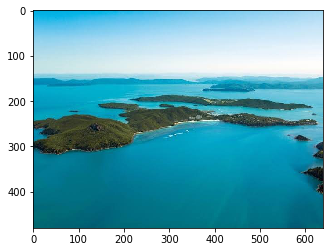

In [16]:
img = mpimg.imread(img_file)
plt.imshow(img)

vec = get_image_vector(img)
print(vec.shape)

spend 0.002711772918701172 second


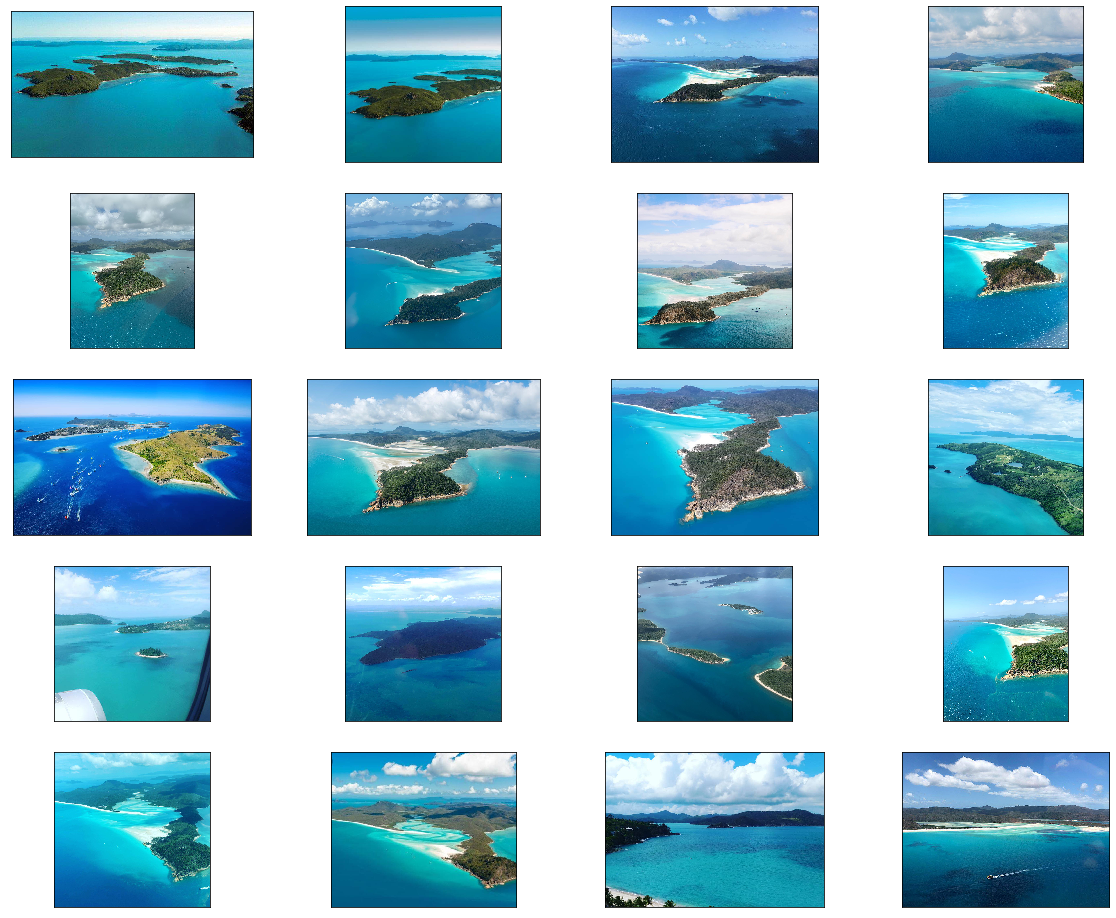

In [17]:
import time

t1 = time.time()
neighbours = annoy.get_nns_by_vector(vec, 20)
t2 = time.time()
print('spend {} second'.format(t2-t1))

def show_similar_images(neighbours):
    fig = plt.figure(figsize=(20, 20))
    cols = 4
    num_of_images = len(neighbours)
    
    for i, indx in enumerate(neighbours):
        _id = i_to_id[indx]
        ax = fig.add_subplot(num_of_images//cols+1, cols, i+1, xticks=[], yticks=[])
        file = os.path.join('data/all_images', _id + '.jpg')
        img = mpimg.imread(file)
        plt.imshow(img)
        

show_similar_images(neighbours)